# 20대 남성 ~ 60대 여성 판매량 예측
- output node를 10개로 설정하여, 한 RNN을 모델을 통해 전 연령/성별에 대한 판매량을 학습 및 예측합니다.

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error

## 데이터 전처리

In [5]:
path = '../data/'
# path = '/content/drive/MyDrive/기상청 데이터/'

X = pd.read_csv(path+'X_Rnn.csv', encoding='CP949')
y = pd.read_csv(path+'y_Rnn.csv', encoding='CP949')

In [6]:
# input data 및 output data를 병합해 원본 데이터를 생성합니다. (처리 편의상)
data_origin = pd.concat([X,y], axis=1)

In [7]:
# 상품 목록을 정의합니다. 
goods = data_origin.loc[:,'소분류_가스온수기':'소분류_히터'].columns.tolist()

In [8]:
# 상품 및 날짜로 데이터를 정렬합니다.
data_origin.sort_values(goods+['날짜'], inplace=True)

In [9]:
# 정렬로 뒤죽박죽이 된 행 인덱스를 초기화합니다. 
data_origin.index = range(0, len(data_origin))

# 여성향수는 표본이 11개로 너무 적습니다. 향후 분석시 제외하도록 하겠습니다.
data_origin[data_origin['소분류_여성향수']==1] 

,날짜,소분류_가스온수기,소분류_가열식 가습기,소분류_감/홍시,소분류_감귤/한라봉/오렌지,소분류_감말랭이,소분류_감자,소분류_건대추,소분류_건포도,소분류_견과류 밤,소분류_계란,소분류_고추/피망/파프리카,소분류_곡물차,소분류_공기정화 용품,소분류_공기청정기,소분류_과일류,소분류_과일채소 분말/분태,소분류_굴 생물,소분류_기능성 아이케어 화장품,소분류_기능성 화이트닝 화장품,소분류_기초 화장용 로션,소분류_기초 화장용 크림,소분류_기타 주스류,소분류_김치류,소분류_난방용 열풍기,소분류_남성 로션,소분류_남성 선케어,소분류_남성 세트,소분류_남성향수,소분류_냉풍기,소분류_네일 메이크업 용품,소분류_다이어트용 헬스보충식품,소분류_대게/킹크랩,소분류_더치커피,소분류_데오드란트,소분류_돈풍기,소분류_둥굴레차,소분류_딸기/복분자/블루베리,소분류_라디에이터,소분류_레몬/자몽,...,소분류_풋크림,소분류_해초류,소분류_핸드크림,소분류_향수세트,소분류_허브차,소분류_헤어스타일링용 흑채,소분류_홍차,소분류_황토매트,소분류_회,소분류_휴대용 선풍기,소분류_히터,평균기온(°C),최저기온(°C),최고기온(°C),최소 상대습도(%),평균 상대습도(%),O3,PM10,20대 남성 판매량(개),20대 여성 판매량(개),30대 남성 판매량(개),30대 여성 판매량(개),40대 남성 판매량(개),40대 여성 판매량(개),50대 남성 판매량(개),50대 여성 판매량(개),60대 남성 판매량(개),60대 여성 판매량(개),합계,일별 물품 선호도 점수,20대 남성 선호도 점수,20대 여성 선호도 점수,30대 남성 선호도 점수,30대 여성 선호도 점수,40대 남성 선호도 점수,40대 여성 선호도 점수,50대 남성 선호도 점수,50대 여성 선호도 점수,60대 남성 선호도 점수,60대 여성 선호도 점수
27975,2018-04-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,16.595529,10.120254,23.418478,25.470465,49.740966,0.049572,59.350384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.031385e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27976,2018-05-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,21.597834,18.305803,26.545326,53.341946,74.620359,0.032977,45.051083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.031385e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27977,2018-07-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,27.647878,24.909222,31.438373,58.914911,77.393433,0.016366,26.861223,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.652630e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27978,2018-08-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,26.233502,23.169520,29.288186,65.041812,83.634330,0.010659,20.063412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.909181e-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27979,2018-10-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,14.156018,8.085875,21.178390,30.691884,61.459397,0.015276,46.770737,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.652630e-07,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27980,2018-11-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,9.443761,5.464574,14.870047,39.750625,62.451893,0.016076,39.273873,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.628522e-07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27981,2019-03-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,7.228955,3.210187,13.160435,24.735145,54.616292,0.030124,38.294831,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.062724e-07,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27982,2019-06-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,22.048594,16.103109,27.695437,36.868798,61.387975,0.035561,32.304425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.031385e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27983,2019-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,23.787409,20.876148,28.179512,56.553388,80.566141,0.034418,30.448931,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.298794e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
27984,2019-10-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,15.664271,14.162826,18.530472,64.363326,90.403753,0.014386,13.943718,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.812512e-07,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 여성향수 데이터를 삭제합니다.
data_origin = data_origin[data_origin['소분류_여성향수']==0]

# 여성향수 원핫인코딩 열을 삭제합니다.
del data_origin['소분류_여성향수']

In [11]:
# 모델의 성능 향상을 위해 MinMaxScale을 진행합니다.

sale_sc = MinMaxScaler(feature_range = (0, 1)) # 판매량 scaler
mean_temp_sc = MinMaxScaler(feature_range = (0, 1)) # 평균온도 scaler
min_temp_sc = MinMaxScaler(feature_range = (0, 1)) # 최저온도 scaler
max_temp_sc = MinMaxScaler(feature_range = (0, 1)) # 최고온도 scaler
min_humid_sc = MinMaxScaler(feature_range = (0, 1)) # 최저상대습도 scaler
mean_humid_sc = MinMaxScaler(feature_range = (0, 1)) # 평균상대습도 scaler
ozon_sc = MinMaxScaler(feature_range = (0, 1)) # 오존 scaler
dust_sc = MinMaxScaler(feature_range = (0, 1)) # 미세먼지 scaler

# 각 데이터에 대한 scaler로 MinMaxScale을 진행합니다.
sale_scaled = sale_sc.fit_transform(data_origin.loc[:,'20대 남성 판매량(개)':'60대 여성 판매량(개)'].values.reshape(-1,10))
mean_temp_scaled = mean_temp_sc.fit_transform(data_origin['평균기온(°C)'].values.reshape(-1,1))
min_temp_scaled = min_temp_sc.fit_transform(data_origin['최저기온(°C)'].values.reshape(-1,1))
max_temp_scaled = max_temp_sc.fit_transform(data_origin['최고기온(°C)'].values.reshape(-1,1))
min_humid_scaled = min_humid_sc.fit_transform(data_origin['최소 상대습도(%)'].values.reshape(-1,1))
mean_humid_scaled = mean_humid_sc.fit_transform(data_origin['평균 상대습도(%)'].values.reshape(-1,1))
ozon_scaled = ozon_sc.fit_transform(data_origin['O3'].values.reshape(-1,1))
dust_scaled = dust_sc.fit_transform(data_origin['PM10'].values.reshape(-1,1))

# 반드시 판매량 데이터를 마지막 열에 두어야 합니다.
# scale된 데이터를 병합해서 total data를 생성합니다.
# 상품 소분류 원핫인코딩 열은 MinMaxScale을 진행하지 않았습니다. (0과 1로 이루어졌으므로)
total = np.hstack([data_origin.loc[:,'소분류_가스온수기':'소분류_히터'].values,
                   mean_temp_scaled,min_temp_scaled,
                   max_temp_scaled,min_humid_scaled,
                   mean_humid_scaled,ozon_scaled,
                   dust_scaled, sale_scaled])

In [12]:
# 가스온수기 판매 데이터 개수의 70% 입니다.
index =int(len(data_origin[data_origin['소분류_가스온수기']==1]) * 0.7)

# 가스온수기 판매 데이터의 70%를 train data로, 30%를 test data로 정의합니다.
train = total[data_origin['소분류_가스온수기']==1][:index]
test = total[data_origin['소분류_가스온수기']==1][index:]

# 전체 상품 목록 리스트
goods = data_origin.loc[:,'소분류_가스온수기':'소분류_히터'].columns.tolist()

# 각 상품의 판매 데이터의 70%는 train, 30%는 test data에 추가합니다. 
for good in goods[1:]:
  index =int(len(data_origin[data_origin[good]==1]) * 0.7)
  train = np.vstack([train, total[data_origin[good]==1][:index]])
  test = np.vstack([test, total[data_origin[good]==1][index:]])

In [13]:
X_train = [] 
y_train = []

day = 20

# good_index는 상품의 인덱스를 의미합니다.
# 총 '127'개의 상품이 있습니다. 
for good_index in range(0, 127): 

  # 해당 인덱스의 상품에 대한 판매 데이터만 추출합니다.
  df = train[train[:, good_index]==1] 

  # 해당 판매 데이터를 day 기준으로 분할합니다.(20일)
  for i in range(day, df.shape[0]):
      X_train.append(df[i-day:i, :])
      y_train.append(df[i, -10:])

# numpy 배열로 변환합니다.
X_train, y_train = np.array(X_train), np.array(y_train)

# X_train의 shape을 재정의합니다. 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

In [14]:
# test 데이터도 위와 같이 생성합니다.

X_test = []
y_test = []

day = 20

for good_index in range(0, 127):
  df = test[test[:, good_index]==1]
  for i in range(day, df.shape[0]):
      X_test.append(df[i-day:i, :])
      y_test.append(df[i, -10:])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

## 학습 및 예측

In [16]:
with tf.device('/device:GPU:0'):

  regressor = Sequential()

  # 모델 정의
  regressor.add(LSTM(units = 100, return_sequences = True, 
                    input_shape = (X_train.shape[1], X_train.shape[2]))) 
  regressor.add(Dropout(0.4, seed = 1))
  regressor.add(LSTM(units = 100, return_sequences = True)) 
  regressor.add(Dropout(0.4, seed = 2))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 3))
  regressor.add(LSTM(units = 100, return_sequences = True))
  regressor.add(Dropout(0.4, seed = 4))
  regressor.add(LSTM(units = 100))
  regressor.add(Dropout(0.4, seed = 5))
  regressor.add(Dense(units = 10))

  # 모델 compile
  regressor.compile(optimizer = 'adam', loss = 'mean_squared_error') 

  # 모델 fitting
  regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

  # test data를 통한 예측
  pre_sale_total = regressor.predict(X_test) 

Epoch 1/100
1676/1676 [==============================] - 25s 12ms/step - loss: 5.4007e-04
Epoch 2/100
1676/1676 [==============================] - 20s 12ms/step - loss: 4.1646e-04
Epoch 3/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.9450e-04
Epoch 4/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.7250e-04
Epoch 5/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.5810e-04
Epoch 6/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.4968e-04
Epoch 7/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.4621e-04
Epoch 8/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.3403e-04
Epoch 9/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.3207e-04
Epoch 10/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.1889e-04
Epoch 11/100
1676/1676 [==============================] - 20s 12ms/step - loss: 3.2159e-04
Epoch 12

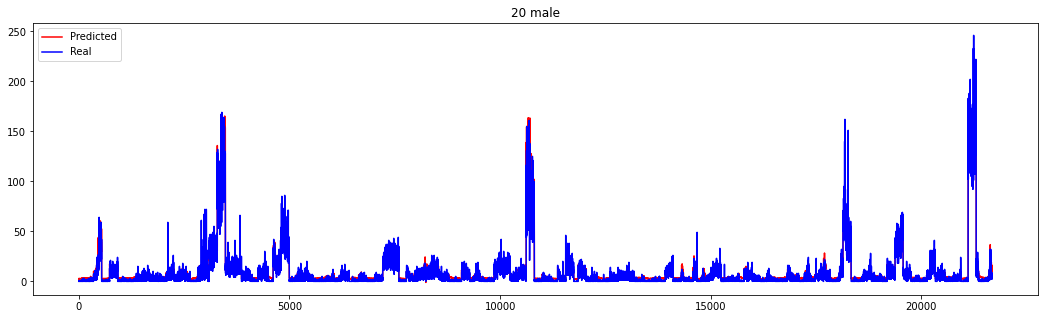

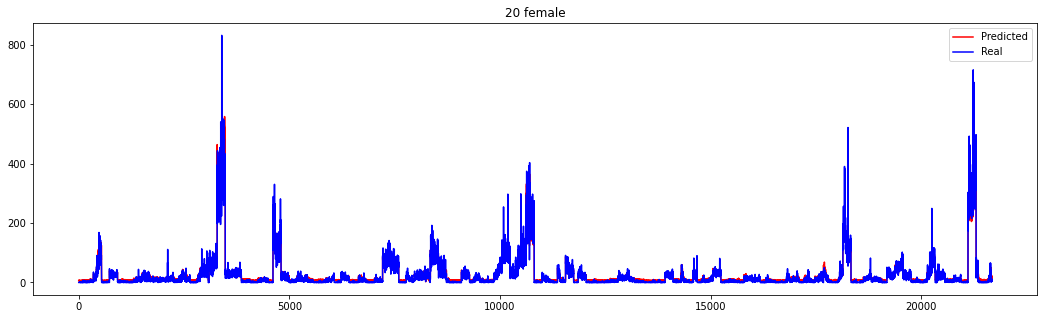

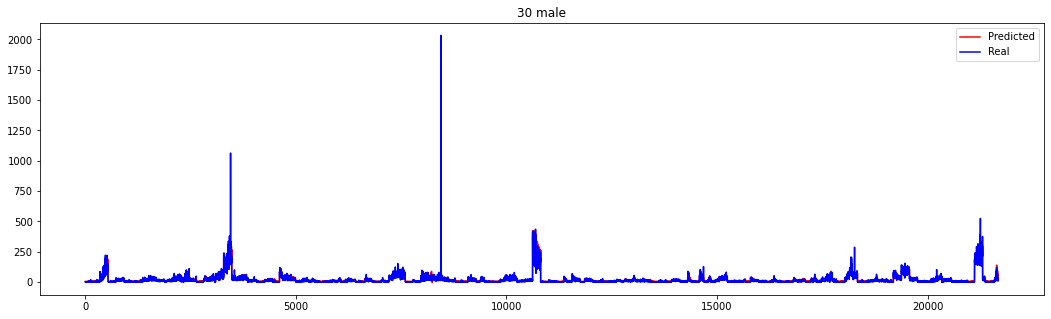

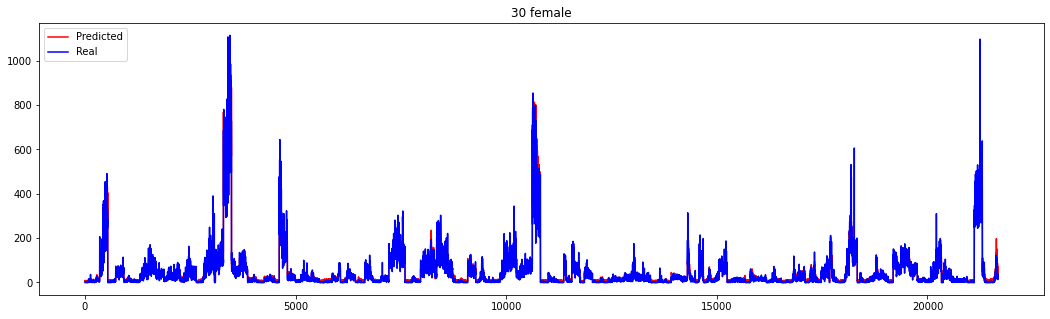

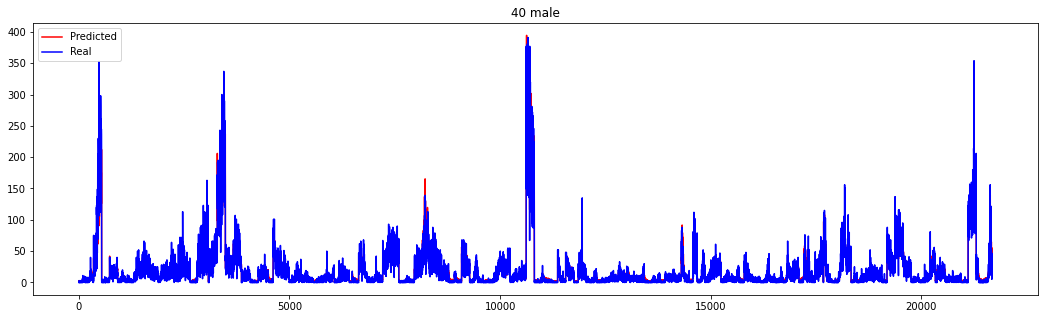

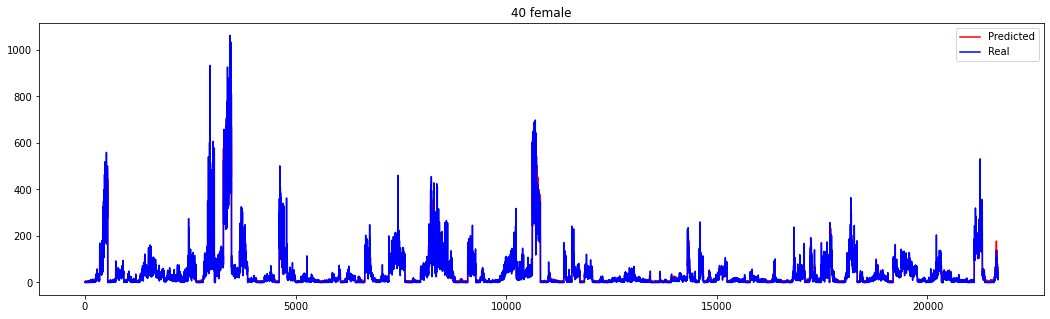

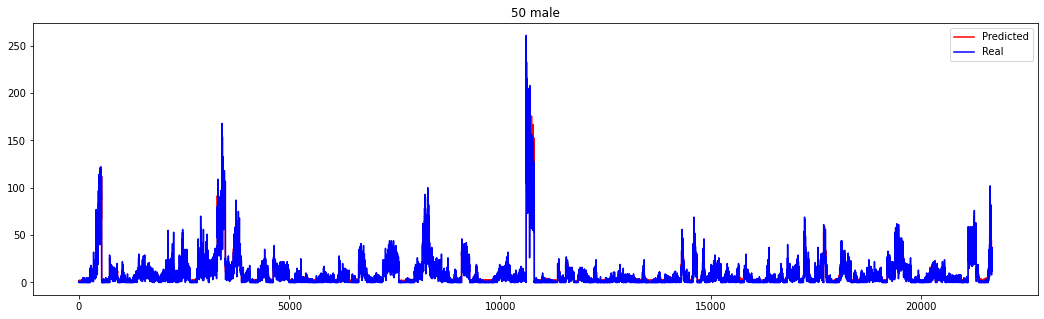

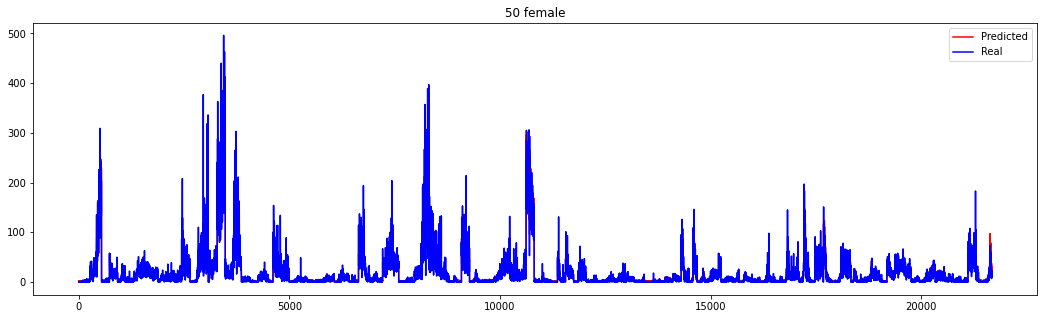

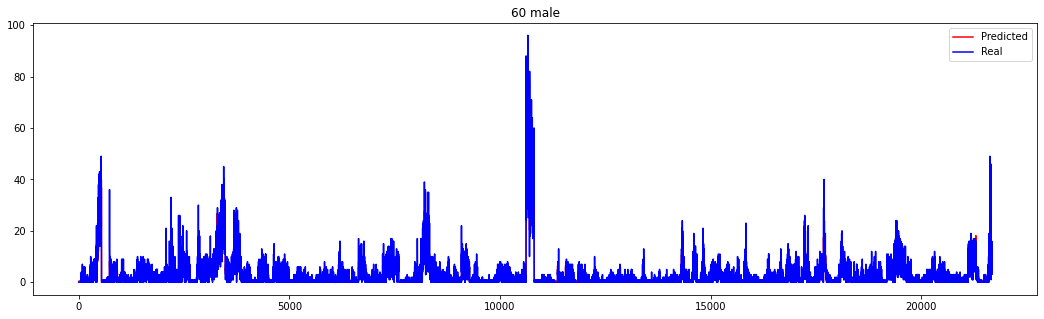

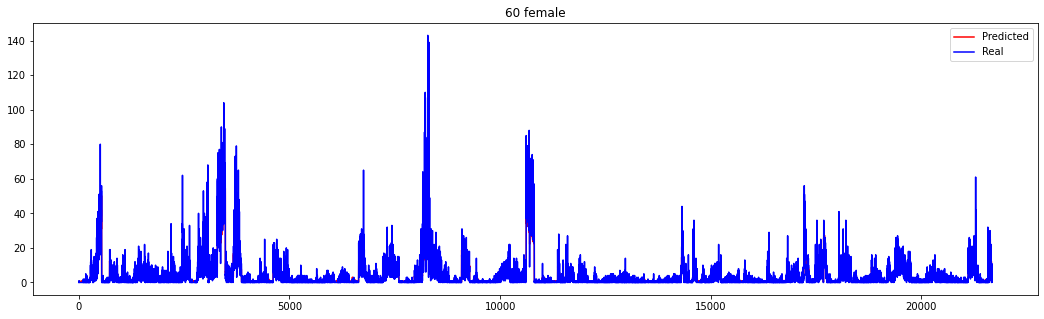

In [17]:
# 예측값과 실제값의 비교를 위해 scale 이전의 상태로 되돌립니다.
pre_val = sale_sc.inverse_transform(pre_sale_total.reshape(-1, 10))
true_val = sale_sc.inverse_transform(y_test.reshape(-1, 10))

age = ['20 male', '20 female',
       '30 male', '30 female',
       '40 male', '40 female',
       '50 male', '50 female',
       '60 male', '60 female',]

for index in range(10):  
  plt.figure(figsize=(18,5))
  plt.plot(pre_val[:, index], color = 'red', label = 'Predicted') # 예측값 plot
  plt.plot(true_val[:, index], color = 'blue', label = 'Real') # 실제값 plot
  plt.legend()
  plt.title(age[index])
  plt.show()

In [18]:
mse = mean_squared_error(pre_val, true_val)
print('MSE:', mse)
print('RMSE:', np.sqrt(mse))

MSE: 244.21561683898852
RMSE: 15.62739955459604
